# gomecc_map_contour.ipynb

### Import packages

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.transforms
import matplotlib.lines as mlines
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

### Functions

In [3]:
def mixs_to_numeric(value_plus_units):
    '''Takes a value with units after it (str) and returns only the numeric value (float)'''
    '''Does not support scientific notation (yet)'''
    '''Inputs containing no numerals or dash or period will return np.nan'''
    value_only = re.sub(r'([-\.0-9]*).*', r'\1', value_plus_units)
    if value_only == '':
        return(np.nan)
    else:
        return(float(value_only))

In [4]:
# these are not used
def get_mod_tenth(num):
    return round(round(num, 6) % 0.1, 6)

def get_mod_tenth_bool(num):
    return (round(round(num, 6) % 0.1, 6) % 0.1 == 0)

### Colors & styles

In [5]:
dict_colors_clusters = {'Cluster 1': '#BB5566', 'Cluster 2': '#DDAA33', 'Cluster 3': '#004488'}
dict_colors_alternate = {'Cluster 1': '#DB5339', 'Cluster 2': '#F7CDA4', 'Cluster 3': '#0E899F'}

In [6]:
# line colors
dict_colors_lines = {
    '27N': '#A6CEE2',
    'BISCNP': '0.8',
    'BROWNSVILLE': '#FBB35C',
    'CAMPECHE': '#B194C5',
    'CANCUN': '#B25A29',
    'CAPECORAL': '#579FA4',
    'CATOCHE': '#E6CB76',
    'DRYTTGNP': '0.8',
    'FLSTRAITS': '#4992C3',
    'GALVESTON': '#E73534',
    'LA': '#F58A8A',
    'MERIDA': '#70469C',
    'PAISNP': '#EF6C46',
    'PANAMACITY': '#53AF47',
    'PENSACOLA': '#8A9D5B',
    'TAMPA': '#ABD484',
    'TAMPICO': '#F6871F',
    'VERACRUZ': '#E29C79',
    'YUCATAN': '#C7B699'
}

In [7]:
sns.set_style('white', {'axes.facecolor': 'none', 'figure.facecolor': 'white', 'grid.color': '1', 'grid.linestyle': '-'})
sns.set_style()

### Exclude samples

From Sean: There are a few samples that cluster in either surface or deep that I could not account for. I end up just removing these from downstream analyses:

- GOMECC4_CAPECORAL_Sta140_Deep_C
- GOMECC4_LA_Sta38_Deep_C
- GOMECC4_FLSTRAITS_Sta123_Surface_B

In [8]:
exclude = ['GOMECC4_CAPECORAL_Sta140_Deep_C',
           'GOMECC4_LA_Sta38_Deep_C',
           'GOMECC4_FLSTRAITS_Sta123_Surface_B']

### Sample data

In [9]:
df_samp = pd.read_excel(
    '/Users/luke.thompson/gomecc/metadata/gomecc4_AOML_MIMARKS.survey.water.6.0_20230922_water_sample_data.xlsx',
    skiprows=7)

df_samp = df_samp[~df_samp['*sample_name'].isin(exclude)]

df_samp['depth'] = [re.sub(' m', '', x) for x in df_samp['*depth']]

df_samp['decimalLatitude'] = pd.to_numeric(df_samp['decimalLatitude'], errors='coerce')
df_samp['decimalLongitude'] = pd.to_numeric(df_samp['decimalLongitude'], errors='coerce')
df_samp['depth'] = pd.to_numeric(df_samp['depth'], errors='coerce')

# columns to plot
df_samp['temp_num'] = [mixs_to_numeric(x) for x in df_samp['temp'].astype(str)]
df_samp['salinity_num'] = [mixs_to_numeric(x) for x in df_samp['salinity'].astype(str)]
df_samp['diss_oxygen_num'] = [mixs_to_numeric(x) for x in df_samp['diss_oxygen'].astype(str)]
df_samp['nitrate_num'] = [mixs_to_numeric(x) for x in df_samp['nitrate'].astype(str)]
df_samp['silicate_num'] = [mixs_to_numeric(x) for x in df_samp['silicate'].astype(str)]
df_samp['phosphate_num'] = [mixs_to_numeric(x) for x in df_samp['phosphate'].astype(str)]
df_samp['ammonium_num'] = [mixs_to_numeric(x) for x in df_samp['ammonium'].astype(str)]
df_samp['diss_inorg_carb_num'] = [mixs_to_numeric(x) for x in df_samp['diss_inorg_carb'].astype(str)]
df_samp['ph_num'] = [mixs_to_numeric(x) for x in df_samp['ph'].astype(str)]
df_samp['dna_yield_num'] = [mixs_to_numeric(x) for x in df_samp['dna_yield'].astype(str)]
df_samp['samp_vol_we_dna_ext_num'] = [mixs_to_numeric(x) for x in df_samp['samp_vol_we_dna_ext'].astype(str)]
df_samp['tot_depth_water_col_num'] = [mixs_to_numeric(x) for x in df_samp['tot_depth_water_col'].astype(str)]

df_samp['dna_yield_per_liter'] = df_samp['dna_yield_num']/df_samp['samp_vol_we_dna_ext_num']*1000

df_samp_xyz = df_samp[['decimalLatitude','decimalLongitude', 'depth', 'line_id', 'temp_num', 'salinity_num', 
                       'diss_oxygen_num', 'nitrate_num', 'silicate_num', 'phosphate_num', 'ammonium_num', 
                       'diss_inorg_carb_num', 'ph_num', 'tot_depth_water_col_num', 'dna_yield_per_liter', 
                       'cluster_16s', 'cluster_18s']]

df_samp_xyz = df_samp_xyz.dropna()

df_samp_xyz.loc[:, 'depth'] = [np.log10(z) * -1 for z in df_samp_xyz.loc[:, 'depth']]

df_samp_xyz.drop_duplicates(inplace=True)

Sample data with replicates grouped and averaged:

In [10]:
df_samp_xyz_pt1 = df_samp_xyz.groupby(['decimalLatitude', 'decimalLongitude', 'depth', 'line_id', 
                     'temp_num', 'salinity_num', 'diss_oxygen_num', 'nitrate_num', 'silicate_num', 
                     'phosphate_num', 'ammonium_num', 'diss_inorg_carb_num', 'ph_num', 
                     'tot_depth_water_col_num'])[['cluster_16s', 'cluster_18s']].agg(pd.Series.mode).reset_index()

In [11]:
df_samp_xyz_pt2 = df_samp_xyz.groupby(['decimalLatitude', 'decimalLongitude', 'depth'])['dna_yield_per_liter'].mean().reset_index()

In [12]:
df_samp_xyz_group = pd.merge(df_samp_xyz_pt1, df_samp_xyz_pt2, on=['decimalLatitude', 'decimalLongitude', 'depth'])

DataFrame for plumb lines:

In [13]:
df_samp_xyz_plumb = df_samp_xyz_group.groupby(['decimalLatitude', 'decimalLongitude', 'line_id', 
                                               'tot_depth_water_col_num'])[['depth']].max().reset_index()
df_samp_xyz_plumb.loc[:, 'tot_depth_water_col_num'] = [
    np.log10(z) * -1 for z in df_samp_xyz_plumb.loc[:, 'tot_depth_water_col_num']]
surface = 1
df_samp_xyz_plumb['surface'] = np.log10(surface) * -1
df_samp_xyz_plumb.columns = ['decimalLatitude', 'decimalLongitude', 'line_id', 'bottom_depth', 
                             'shallowest_sample', 'surface_depth']

### Bottle data

Bottle data is used to plot the non-eDNA stations.

In [14]:
df_bottle = pd.read_excel('/Users/luke.thompson/gomecc/metadata/GOMECC-4 prelim bottle file copy.xlsx')

In [15]:
df_stn = df_bottle.drop(0, axis=0)[['STATION_ID', 'LATITUDE_DEC', 'LONGITUDE_DEC', 'GOMECC-4 LINE']
                                  ].drop_duplicates().reset_index(drop=True)
df_stn.columns = ['STN', 'LAT', 'LON', 'LINE']
df_stn = df_stn.drop_duplicates(subset=['STN', 'LINE']).reset_index(drop=True)

### Bathymetry data

Load and convert map data (GEBCO_2022 Grid)

https://www.gebco.net/data_and_products/gridded_bathymetry_data/

The GEBCO_2022 Grid was published in June 2022 and is a global terrain model for ocean and land, providing elevation data, in meters, on a 15 arc-second interval grid.

Download region: https://download.gebco.net/ (Esri ASCII raster)

In [16]:
path = '/Users/luke.thompson/NOAA/maps/gebco/GEBCO_27_Mar_2023_eab49e5acf3d/gebco_2022_n31.0_s17.0_w-100.0_e-78.0.asc'
path_out1 = '/Users/luke.thompson/NOAA/maps/Python/gebco_2022_n31.0_s17.0_w-100.0_e-78.0.xyz'

In [17]:
# dimensions from first 5 rows of asc file
ncols = 5280
nrows = 3360
xllcorner = -100.000000000000
yllcorner = 17.000000000000
cellsize = 0.004166666667

cols = np.arange(xllcorner, xllcorner+ncols*cellsize, cellsize)
rows = np.arange(yllcorner, yllcorner+nrows*cellsize, cellsize)

df = pd.read_csv(path, sep=' ', skiprows=6, header=None, skipinitialspace=True)
df.index = rows
df.columns = cols

dfunstack = df.unstack()
dfunstack.to_csv(path_out1, header=False)

In [18]:
dfu = pd.read_csv(path_out1, index_col=False)
dfu.columns = ['lon', 'lat', 'alt']
#dfu['alt_neg_log'] = [np.log10(z) * -1 for z in dfu.loc[:, 'alt']]

In [19]:
# transpose lat column for map to appear correctly
df2 = dfu.copy(deep=True)
df2['lat'] = df2['lat'].values[::-1]

In [20]:
# round depth to nearest 10 m for depths below 200 m to get more resolution
df2['alt_round'] = [round(x,-1) if x < -200 else x for x in df2.alt]
#df2['alt_round'] = [round(x,-2) if x < -1000 else x for x in df2.alt]

### Map – contour

To add:
- add surface lines connecting cruise lines (colored by cruise line)
- color marker edges by cruise lines

In [21]:
depths = [-1, -3, -10, -33, -100, -330, -1000, -3300]

In [22]:
sns.color_palette("ocean_r", len(depths))

[(0.6705882352941175, 0.8352941176470587, 0.8901960784313725),
 (0.3411764705882354, 0.6705882352941177, 0.7803921568627451),
 (0.0, 0.5, 0.6666666666666667),
 (0.0, 0.33529411764705885, 0.5568627450980392),
 (0.0, 0.16470588235294115, 0.44313725490196076),
 (0.0, 0.0, 0.33333333333333337),
 (0.0, 0.17058823529411765, 0.2196078431372549),
 (0.0, 0.33529411764705874, 0.1098039215686275)]

In [23]:
plotvars = ['temp_num', 'salinity_num', 'diss_oxygen_num', 'nitrate_num', 'silicate_num', 'phosphate_num', 
            'ammonium_num', 'diss_inorg_carb_num', 'ph_num', 'dna_yield_per_liter', 'cluster_16s', 'cluster_18s']

varlabels = {'temp_num': 'Temperature (°C)', 
             'salinity_num': 'Salinity (psu)', 
             'diss_oxygen_num': 'Diss. oxygen (µmol/kg)', 
             'nitrate_num': 'Nitrate (µmol/kg)', 
             'silicate_num': 'Silicate (µmol/kg)', 
             'phosphate_num': 'Phosphate (µmol/kg)', 
             'ammonium_num': 'Ammonium (µmol/kg)', 
             'diss_inorg_carb_num': 'Diss. inorg. carbon (µmol/kg)', 
             'ph_num': 'pH', 
             'dna_yield_per_liter': 'DNA extracted (ng) per L seawater filtered',
             'cluster_16s': 'Cluster (16S)',
             'cluster_18s': 'Cluster (18S)'}

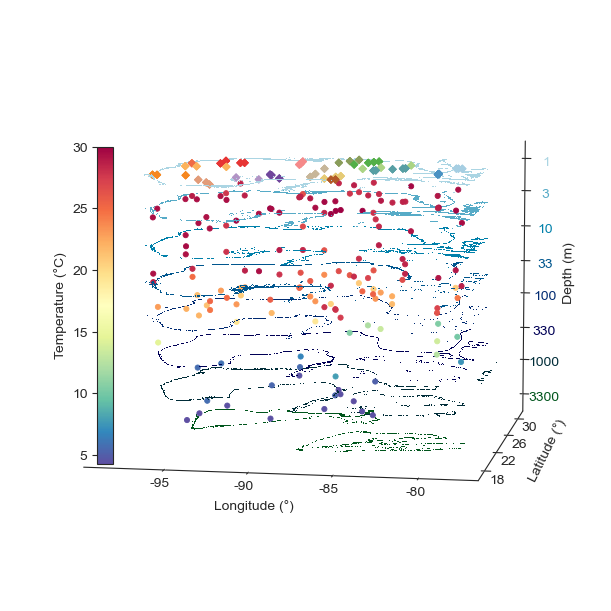

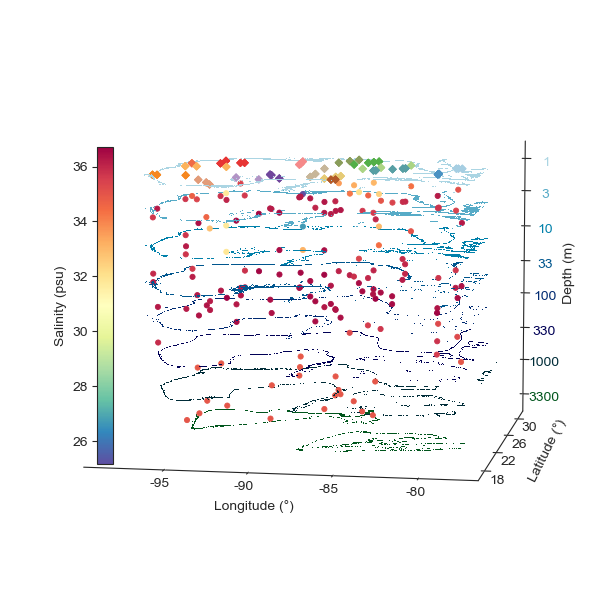

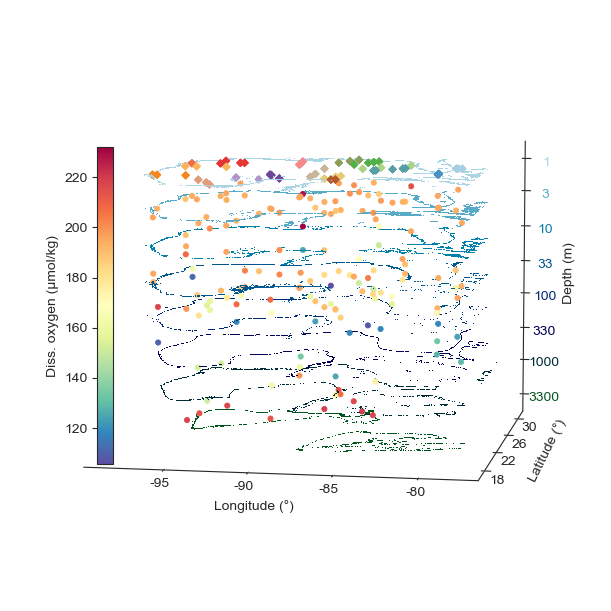

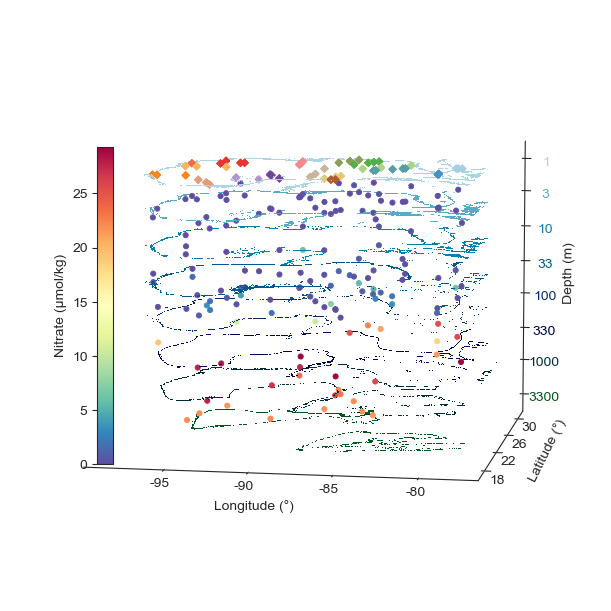

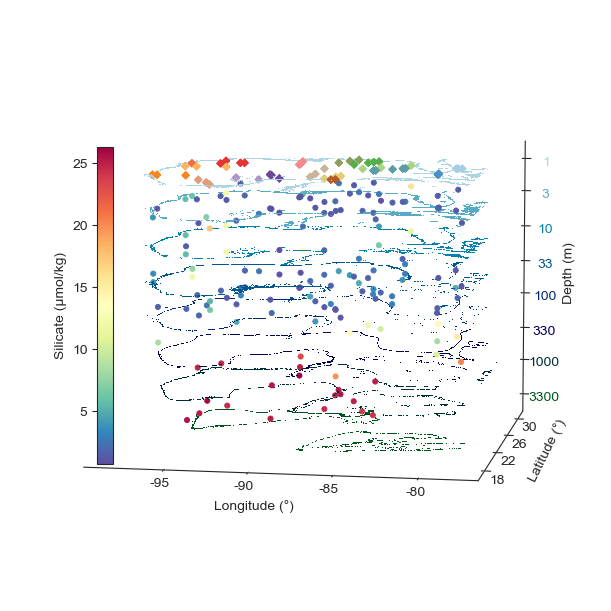

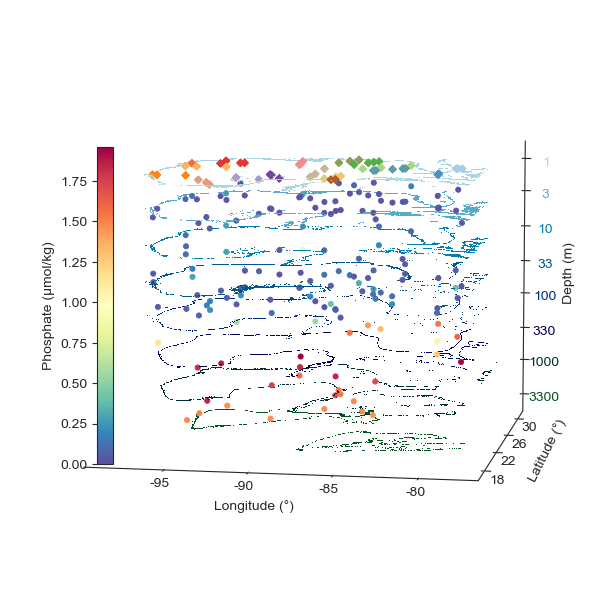

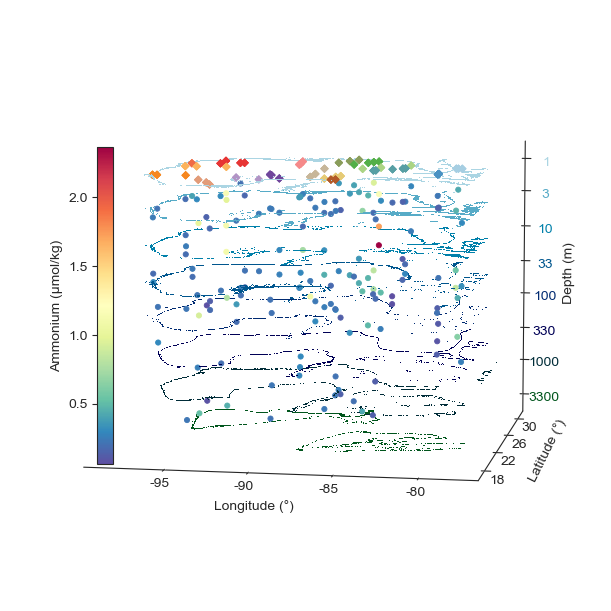

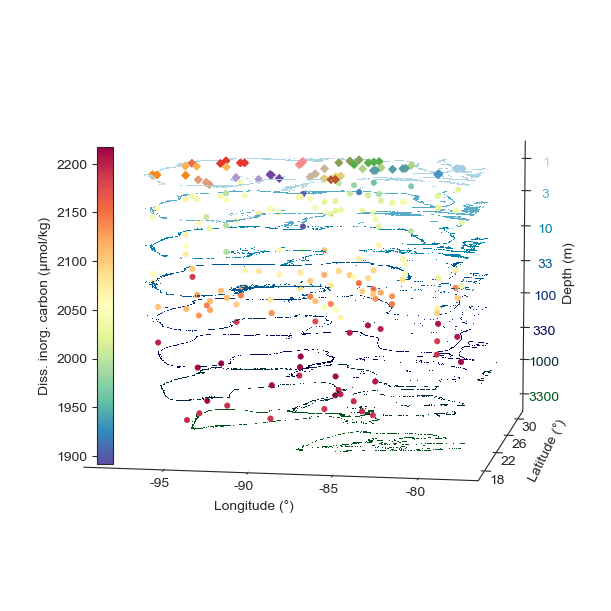

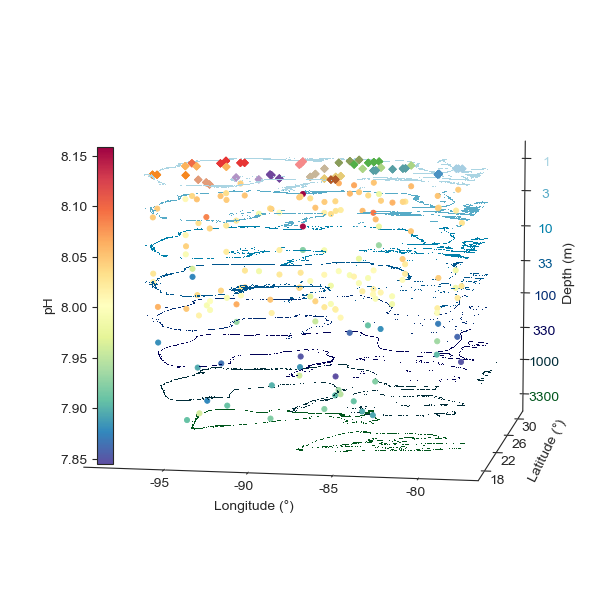

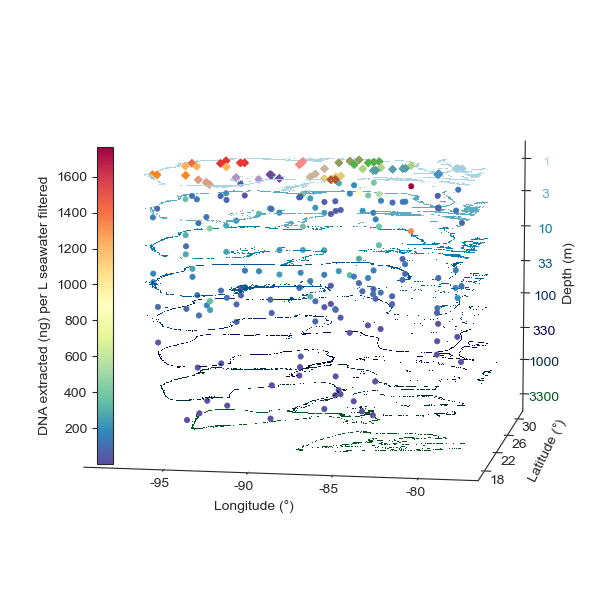

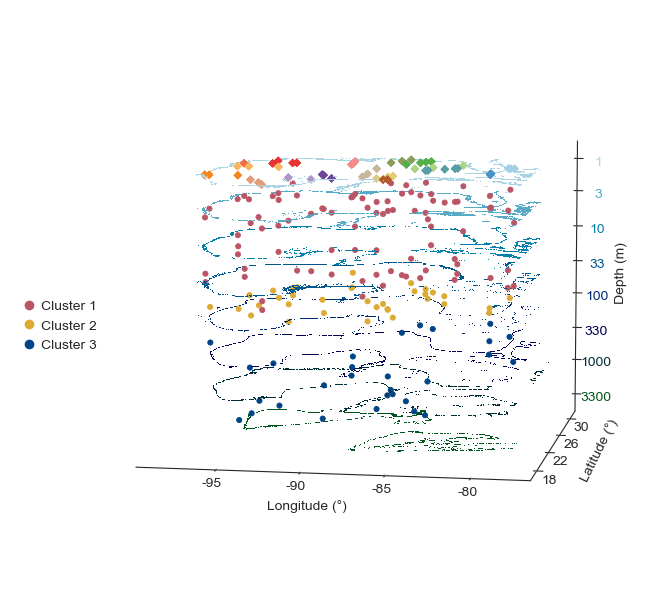

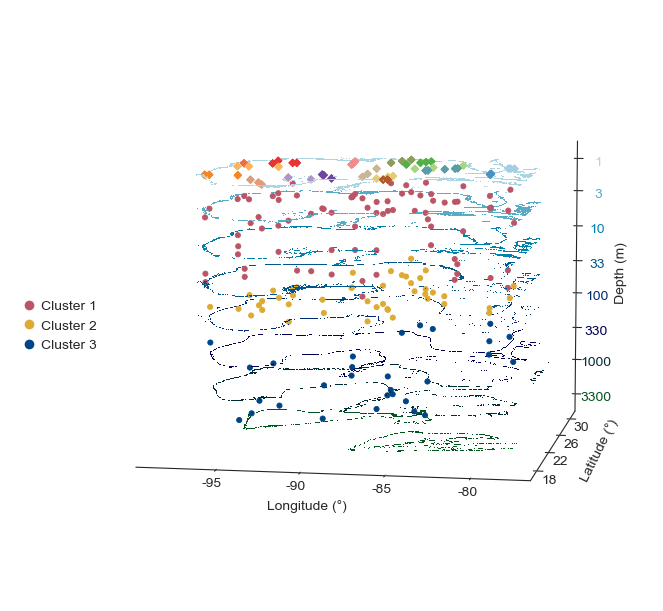

In [28]:
for var in plotvars:

    fig = plt.figure(figsize=(10.24, 7.68))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=8, azim=280, roll=0)

    # PLUMB LINES
    #for index, row in df_samp_xyz_plumb.iterrows():
    #    ax.plot([row['decimalLongitude'], row['decimalLongitude']], 
    #            [row['decimalLatitude'], row['decimalLatitude']], 
    #            [row['surface_depth'], row['bottom_depth']],
    #            color=dict_colors_lines[row['line_id']], linewidth=0.3, zorder=0)
    
    # DIAMONDS - ALL STATIONS - NOT PLOTTING
    #b = ax.scatter3D(df_stn.LON, df_stn.LAT, 0,
    #                 s=14, linewidths=0.6, c='w', marker='D',
    #                 edgecolors=[dict_colors_lines[row[1]['LINE']] for row in df_stn.iterrows()],
    #                 alpha=1.0, label='No DNA sampled')

    # DIAMONDS - DNA STATIONS
    a = ax.scatter3D(df_samp_xyz_group.decimalLongitude, df_samp_xyz_group.decimalLatitude, 0,
                     s=14, linewidths=0.6, marker='D',
                     c=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()], 
                     edgecolors=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()], 
                     alpha=1.0, label='DNA sampled')
    
    # CIRCLES - DNA SAMPLES
    if any(var == i for i in ['cluster_16s', 'cluster_18s']):
        a = ax.scatter3D(df_samp_xyz_group.decimalLongitude, 
                         df_samp_xyz_group.decimalLatitude, 
                         df_samp_xyz_group.depth, 
                         s=14, linewidths=0.6, 
                         c=df_samp_xyz_group[var].map(dict_colors_clusters), 
                         #edgecolors=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()], 
                         alpha=1.0, zorder=5)
    else:
        a = ax.scatter3D(df_samp_xyz_group.decimalLongitude, 
                         df_samp_xyz_group.decimalLatitude, 
                         df_samp_xyz_group.depth, 
                         s=14, linewidths=0.6, 
                         c=df_samp_xyz_group[var], 
                         cmap = plt.cm.Spectral_r, 
                         #edgecolors=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()], 
                         alpha=1.0, zorder=5)

    # CONTOUR LINES - ZORDER SPLIT BY 22.5N LATITUDE
    layer = 0
    stride = 1
    for d in depths[layer::stride]:
        if d > -200:
            dfd = df2[df2['alt'] == d]
            dfd.loc[:,'alt_plot'] = dfd.loc[:,'alt']
        else:
            dfd = df2[df2['alt_round'] == d]
            dfd.loc[:,'alt_plot'] = dfd.loc[:,'alt_round']
        dfd_north = dfd[dfd.lat >= 22.5]
        dfd_south = dfd[dfd.lat < 22.5]        
        scat = ax.scatter3D(dfd_north.lon, dfd_north.lat, -(np.log10(-dfd_north.alt_plot)), 
                     s=0.15, marker=',', 
                     color=sns.color_palette("ocean_r", 8)[layer], 
                     alpha=1.0, zorder=0, 
                     linewidth=0, edgecolor='none')
        scat = ax.scatter3D(dfd_south.lon, dfd_south.lat, -(np.log10(-dfd_south.alt_plot)), 
                     s=0.15, marker=',', 
                     color=sns.color_palette("ocean_r", 8)[layer], 
                     alpha=1.0, zorder=10, 
                     linewidth=0, edgecolor='none')
        layer += stride

    # AXIS & TICK LABELS
    ax.text(-92, 16, -4.3, 'Longitude (°)', (0,0,0), fontdict={'fontsize':10})
    ax.text(-75, 24, -4.3, 'Latitude (°)', (1,1,0.5), fontdict={'fontsize':10})
    ax.zaxis.set_label_text('Depth (m)', fontdict={'fontsize':10})
    for i in range(len(depths)):
        ax.zaxis.get_ticklabels()[i].set_color(sns.color_palette("ocean_r", 8)[i])

    xticks_loc = [-95, -90, -85, -80] #ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
    ax.xaxis.set_ticklabels([str(i) for i in xticks_loc],
                           horizontalalignment='center', verticalalignment='bottom')

    yticks_loc = [18, 22, 26, 30] #ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
    ax.yaxis.set_ticklabels([str(i) for i in yticks_loc],
                           horizontalalignment='right', verticalalignment='bottom')

    zticks_loc = [-np.log10(-z) for z in depths] #ax.get_zticks().tolist()
    ax.zaxis.set_major_locator(mticker.FixedLocator(zticks_loc))
    ax.zaxis.set_ticklabels([-z for z in depths], horizontalalignment='center')
    
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    # colorbar legend
    if any(var == i for i in ['cluster_16s', 'cluster_18s']):
        scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle='none', 
            c=dict_colors_clusters['Cluster 1'], markeredgecolor = 'none', markersize=7.0, linewidth=0.1, marker='o')
        scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle='none', 
            c=dict_colors_clusters['Cluster 2'], markeredgecolor = 'none', markersize=7.0, linewidth=0.1, marker='o')
        scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle='none', 
            c=dict_colors_clusters['Cluster 3'], markeredgecolor = 'none', markersize=7.0, linewidth=0.1, marker='o')
        ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['Cluster 1', 'Cluster 2', 'Cluster 3'], 
                  numpoints = 1, loc='lower left', bbox_to_anchor=(-0.1,0.4), frameon=False, handletextpad=-0.2)
    else:
        cbar = fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(df_samp_xyz_group[var].min(), 
            df_samp_xyz_group[var].max()), cmap=plt.cm.Spectral_r), ax=ax, fraction=0.02, pad=-0.13, location='left')
        cbar.ax.set_ylabel(varlabels[var])

    #fig.savefig('/Users/luke.thompson/gomecc/figures/maps/map_gom_contour_%s.pdf' % var, bbox_inches='tight')
    fig.savefig('/Users/luke.thompson/gomecc/figures/maps/map_gom_contour_%s.png' % var, dpi=1200, bbox_inches='tight')

### Map – top view

In [25]:
lines = [[26.5,-80.25,'27N'],
    [28.3,-82.7,'TAMPA'],
    [29.8,-85.2,'PANAMACITY'],
    [30.4,-86.6,'PENSACOLA'],
    [29.4,-90.4,'LA'],
    [29.2,-98.3,'GALVESTON'],
    [26.9,-97.4,'PAISNP'],
    [25.6,-96.9,'BROWNSVILLE'],
    [21.8,-97.7,'TAMPICO'],
    [18.3,-92.9,'VERACRUZ'],
    [20.8,-90.3,'CAMPECHE'],
    [21.3,-89.7,'MERIDA'],
    [22.2,-89.4,'YUCATAN'],
    [22,-86.7,'CATOCHE'],
    [21.1,-86.8,'CANCUN'],
    [24,-80.8,'FLSTRAITS'],
    [27.4,-82.5,'CAPECORAL']]

    #[25.1,-80.2,'BISCNP'],
    #[23.8,-84,'DRYTTGNP'],

df_lines = pd.DataFrame(lines, columns = ['LAT', 'LON', 'LINE'])

In [26]:
old_names = ['27N', 'TAMPA', 'PANAMACITY', 'PENSACOLA', 'LA',
'GALVESTON', 'PAISNP', 'BROWNSVILLE', 'TAMPICO', 'VERACRUZ',
'CAMPECHE', 'MERIDA', 'YUCATAN', 'CATOCHE', 'CANCUN', 'FLSTRAITS', 'CAPECORAL']

new_names = ['27 N', 'Tampa', 'Panama City', 'Pensacola', 'LA',
'Galveston', 'Padre Island NS', 'Brownsville', 'Tampico', 'Veracruz',
'Campeche', 'Merida', 'Yucatan', 'Catoche', 'Cancun', 'FL Straits',
'Cape Coral']

dict_translate = dict(zip(old_names, new_names))

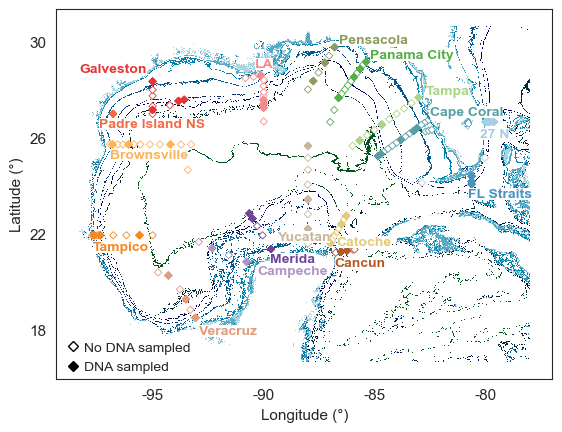

In [27]:
fig = plt.figure(figsize=(6.4, 4.8))
ax = fig.add_subplot()

# CONTOUR LINES
layer = 0
stride = 1
for d in depths[layer::stride]:
    if d > -200:
        dfd = df2[df2['alt'] == d]
        dfd.loc[:,'alt_plot'] = dfd.loc[:,'alt']
    else:
        dfd = df2[df2['alt_round'] == d]
        dfd.loc[:,'alt_plot'] = dfd.loc[:,'alt_round']
    ax.scatter(dfd.lon, dfd.lat, s=0.1, marker=',',
                 color=sns.color_palette("ocean_r", 8)[layer], 
                 linewidth=0, edgecolor='none')
    layer += stride

# DIAMONDS - ALL STATIONS
b = ax.scatter(df_stn.LON, df_stn.LAT, s=14, linewidths=0.6, c='w', marker='D',
               edgecolors=[dict_colors_lines[row[1]['LINE']] for row in df_stn.iterrows()],
               label='No DNA sampled')

# DIAMONDS - DNA STATIONS
a = ax.scatter(df_samp_xyz_group.decimalLongitude, df_samp_xyz_group.decimalLatitude,
               s=14, linewidths=0.6, marker='D',
               c=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()],
               edgecolors=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()], 
               label='DNA sampled')

# LABELS - LINES
for row in df_lines.iterrows():
    ax.text(row[1]['LON'], row[1]['LAT'], dict_translate[row[1]['LINE']], fontdict={'fontsize':10}, 
            color=dict_colors_lines[row[1]['LINE']], horizontalalignment='left',
            verticalalignment='center', weight='bold',
            bbox=dict(facecolor='white', edgecolor='none', pad=0))

ax.xaxis.set_label_text('Longitude (°)', fontdict={'fontsize':11})
ax.yaxis.set_label_text('Latitude (°)', fontdict={'fontsize':11})

# LEGEND
unfilled_black_diamond = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='black', marker='D', 
                                     linestyle='None', markersize=5, linewidth=0.6, label='No DNA sampled')
filled_black_diamond = mlines.Line2D([], [], markerfacecolor='black', markeredgecolor='black', marker='D', 
                                     linestyle='None', markersize=5, linewidth=0.6, label='DNA sampled')
ax.legend(handles=[unfilled_black_diamond, filled_black_diamond], loc='lower left', 
          bbox_to_anchor=(-0.02,-0.02), frameon=False, handletextpad=-0.2)

xticks_loc = [-95, -90, -85, -80] #ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
ax.xaxis.set_ticklabels([str(i) for i in xticks_loc], fontdict={'fontsize': 11},
                       horizontalalignment='center', verticalalignment='top')

yticks_loc = [18, 22, 26, 30] #ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
ax.yaxis.set_ticklabels([str(i) for i in yticks_loc], fontdict={'fontsize': 11},
                       horizontalalignment='right', verticalalignment='bottom')

#fig.savefig('/Users/luke.thompson/gomecc/figures/maps/map_gom_contour_top.pdf', bbox_inches='tight')
fig.savefig('/Users/luke.thompson/gomecc/figures/maps/map_gom_contour_top.png', dpi=1200, bbox_inches='tight')

In [32]:
plt.fill_between?

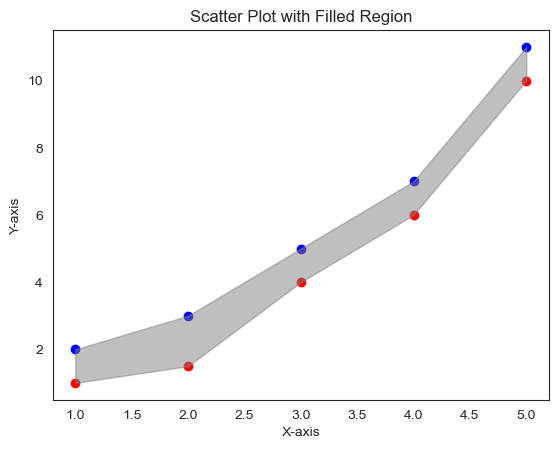

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([2, 3, 5, 7, 11])
y2 = np.array([1, 1.5, 4, 6, 10])

# Create scatter plot
plt.scatter(x, y1, color='blue')
plt.scatter(x, y2, color='red')

# Fill the region between y1 and y2
plt.fill_between(x, y1, y2, color='gray', alpha=0.5)

# Customize plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Filled Region')

# Show plot
plt.show()


In [ ]:
fig = plt.figure(figsize=(6.4, 4.8))
ax = fig.add_subplot()

# CONTOUR LINES
layer = 0
stride = 1
for d in depths[layer::stride]:
    if d > -200:
        dfd = df2[df2['alt'] == d]
        dfd.loc[:,'alt_plot'] = dfd.loc[:,'alt']
    else:
        dfd = df2[df2['alt_round'] == d]
        dfd.loc[:,'alt_plot'] = dfd.loc[:,'alt_round']
    ax.scatter(dfd.lon, dfd.lat, s=0.1, marker=',',
                 color=sns.color_palette("ocean_r", 8)[layer], 
                 linewidth=0, edgecolor='none')
    plt.fill_between(x, y1, y2, color='gray', alpha=0.5)
    layer += stride

# DIAMONDS - ALL STATIONS
b = ax.scatter(df_stn.LON, df_stn.LAT, s=14, linewidths=0.6, c='w', marker='D',
               edgecolors=[dict_colors_lines[row[1]['LINE']] for row in df_stn.iterrows()],
               label='No DNA sampled')

# DIAMONDS - DNA STATIONS
a = ax.scatter(df_samp_xyz_group.decimalLongitude, df_samp_xyz_group.decimalLatitude,
               s=14, linewidths=0.6, marker='D',
               c=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()],
               edgecolors=[dict_colors_lines[row[1]['line_id']] for row in df_samp_xyz_group.iterrows()], 
               label='DNA sampled')

# LABELS - LINES
for row in df_lines.iterrows():
    ax.text(row[1]['LON'], row[1]['LAT'], dict_translate[row[1]['LINE']], fontdict={'fontsize':10}, 
            color=dict_colors_lines[row[1]['LINE']], horizontalalignment='left',
            verticalalignment='center', weight='bold',
            bbox=dict(facecolor='white', edgecolor='none', pad=0))

ax.xaxis.set_label_text('Longitude (°)', fontdict={'fontsize':11})
ax.yaxis.set_label_text('Latitude (°)', fontdict={'fontsize':11})

# LEGEND
unfilled_black_diamond = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='black', marker='D', 
                                     linestyle='None', markersize=5, linewidth=0.6, label='No DNA sampled')
filled_black_diamond = mlines.Line2D([], [], markerfacecolor='black', markeredgecolor='black', marker='D', 
                                     linestyle='None', markersize=5, linewidth=0.6, label='DNA sampled')
ax.legend(handles=[unfilled_black_diamond, filled_black_diamond], loc='lower left', 
          bbox_to_anchor=(-0.02,-0.02), frameon=False, handletextpad=-0.2)

xticks_loc = [-95, -90, -85, -80] #ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(xticks_loc))
ax.xaxis.set_ticklabels([str(i) for i in xticks_loc], fontdict={'fontsize': 11},
                       horizontalalignment='center', verticalalignment='top')

yticks_loc = [18, 22, 26, 30] #ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
ax.yaxis.set_ticklabels([str(i) for i in yticks_loc], fontdict={'fontsize': 11},
                       horizontalalignment='right', verticalalignment='bottom')

#fig.savefig('/Users/luke.thompson/gomecc/figures/maps/map_gom_contour_top.pdf', bbox_inches='tight')
fig.savefig('/Users/luke.thompson/gomecc/figures/maps/map_gom_contour_top.png', dpi=1200, bbox_inches='tight')